In [66]:
library(reticulate)
library(anndata)
library(Seurat)
library(dplyr)
#library(simspec)
library(Matrix)
library(glmnet)
path_data = ''

# Read files

In [2]:
seurat<-readRDS(paste0(path_data, 'exp1_processed_rss_5.rds'))
seurat

An object of class Seurat 
43558 features across 214059 samples within 1 assay 
Active assay: RNA (43558 features, 0 variable features)
 3 dimensional reductions calculated: umap, rss, umap_rss

In [7]:
arches <- as.matrix(paste0(path_data,'parse_scarches.tsv'), row.names = 1, header = TRUE))

rownames(arches) <- colnames(seurat)
seurat[['scvi']] <- CreateDimReducObject(arches, key='SCVI_')


Warning message:
“No assay specified, setting assay as RNA by default.”


In [27]:
braun<-readRDS(file=paste0(path_data,'braun_2022_fetal_brain_v2_RG_subset.seurat.rds'))
braun

An object of class Seurat 
33538 features across 518030 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 4 dimensional reductions calculated: rss, scvi, umap1, umap

In [52]:
#from our paper 
DG <- c("PAX6","GLI3", "BARHL1", "GAS1","EMX1", "WNT2B")
VG <- c("NKX2-1","NKX2-2","SIX6","SIX3","SHH", "RAX", "DLK1", 'FOXA2', 'SPON1', 'SULF1') 
braun <- AddModuleScore(braun, features = list(DG, VG))

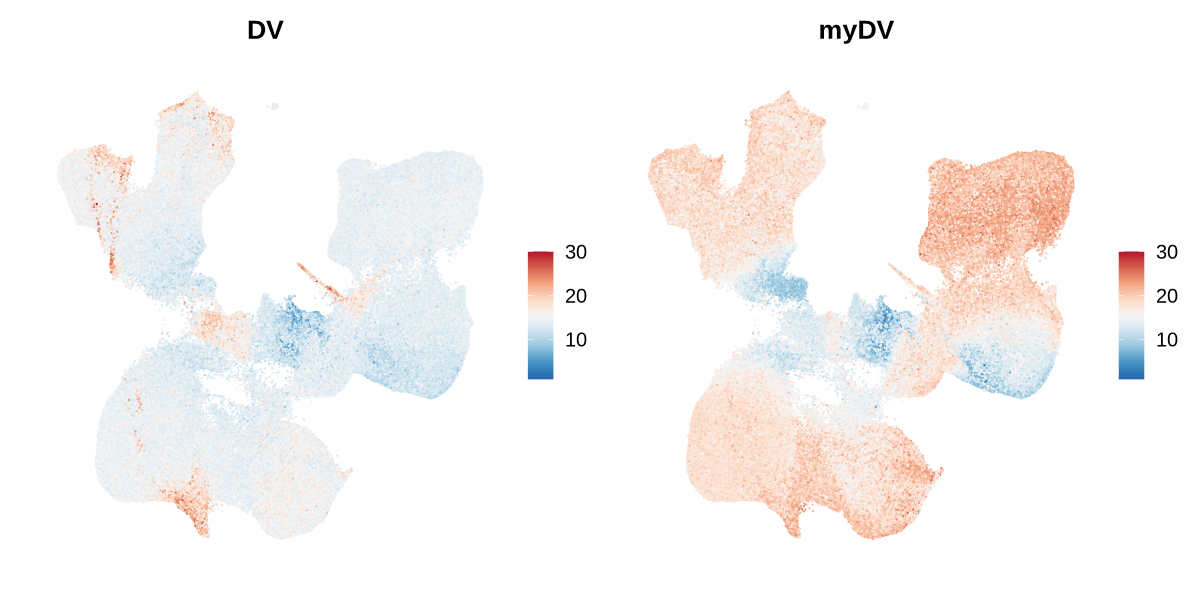

In [53]:
braun$myDV <- braun$Cluster1 - braun$Cluster2

options(repr.plot.width=10, repr.plot.height=5)
FeaturePlot(braun, c('DV', 'myDV'), cols=bluewhitered_colscheme(30), reduction='umap', ncol=2,raster=FALSE) & NoAxes()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.3714 -0.3425 -0.1065 -0.1146  0.1422  1.5425 

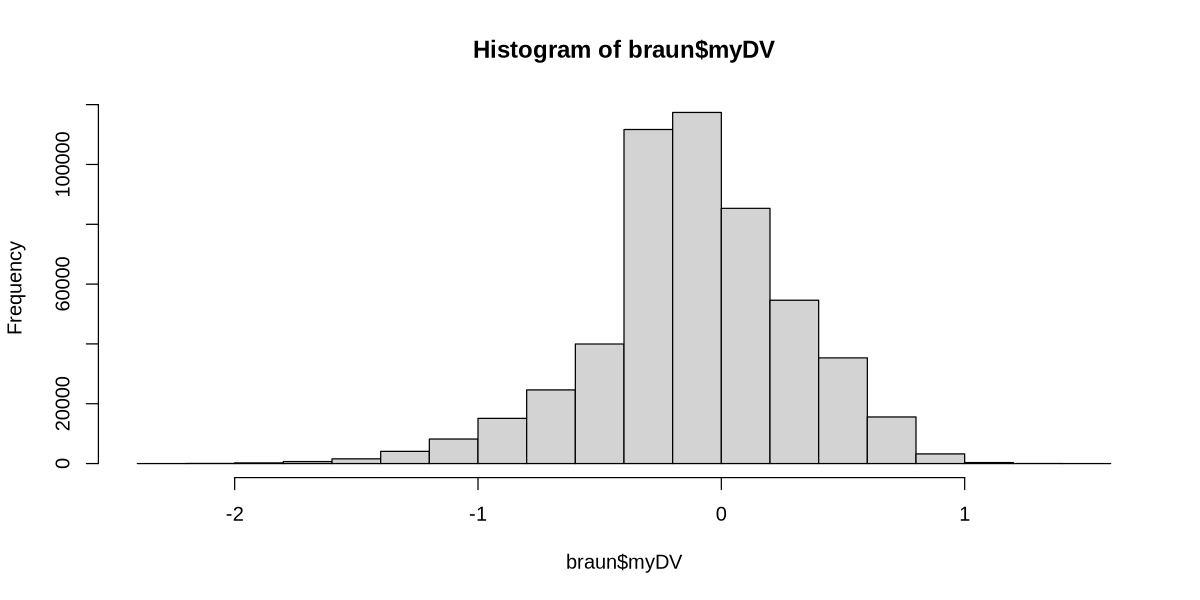

In [54]:
summary(braun$myDV)
hist(braun$myDV)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.082113 -0.062399 -0.016542  0.001679  0.062970  1.237453 

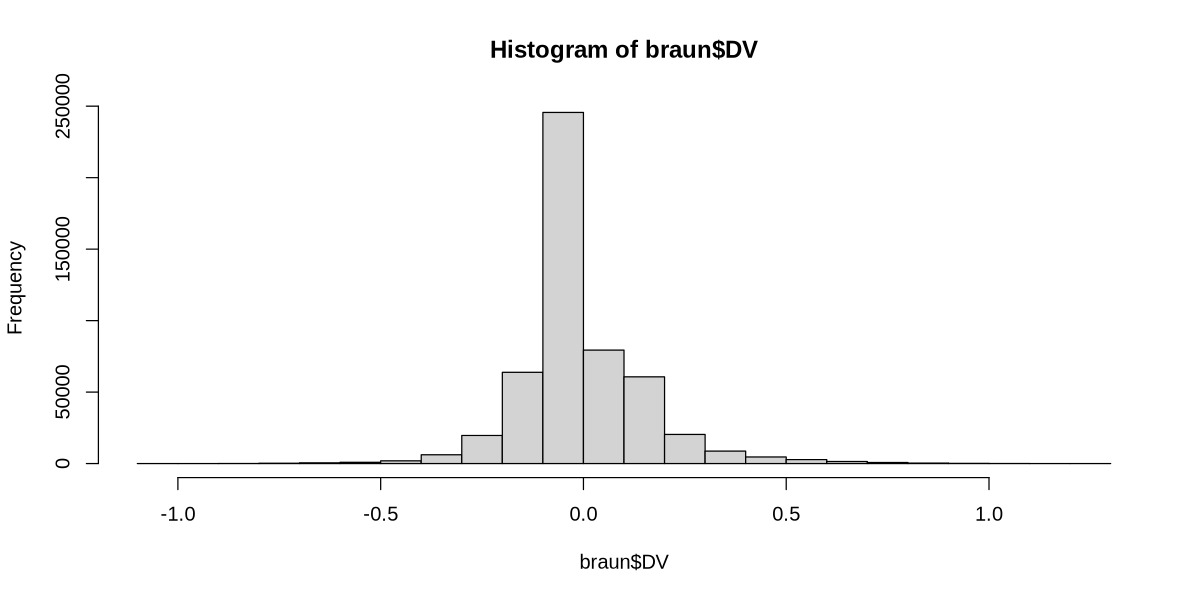

In [55]:
summary(braun$DV)
hist(braun$DV)

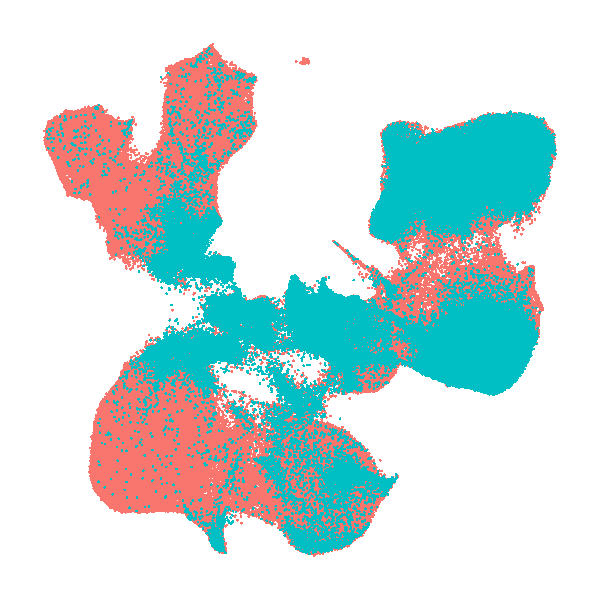

In [56]:
options(repr.plot.height=5, repr.plot.width=5)
par(mar=c(1,1,1,1))
plotFeature(Embeddings(braun,'umap'), factor(abs(braun$myDV)>0.5), cex=0.3, random_order=F, sort_by_value=T)

In [57]:
idx_orger <- which(abs(braun$myDV) > 0.5)
set.seed(12345)
idx_train <- sort(sample(idx_orger, round(length(idx_orger) * 0.8)))
idx_test <- setdiff(idx_orger, idx_train)
c(length(idx_orger),length(idx_train), length(idx_test))

[1] 106252  85002  21250

In [58]:
x_train <- Embeddings(braun,'scvi')[idx_train,]
x_test <- Embeddings(braun,'scvi')[idx_test,]
y_train <- factor(ifelse(braun$myDV[idx_train]>0, 'D','V'))
y_test <- factor(ifelse(braun$myDV[idx_test]>0, 'D','V'))

In [59]:
library(glmnet)

In [60]:
new_DV <- cv.glmnet(x = x_train, y = y_train, family='binomial', type.measure='auc')
pred_test <- predict(new_DV, x_test, type='response')

In [61]:
braun$newDV_glmnet <- predict(new_DV, Embeddings(braun,'scvi'), type='link')
braun$newDV_glmnet = braun$newDV_glmnet*(-1) # D is D"

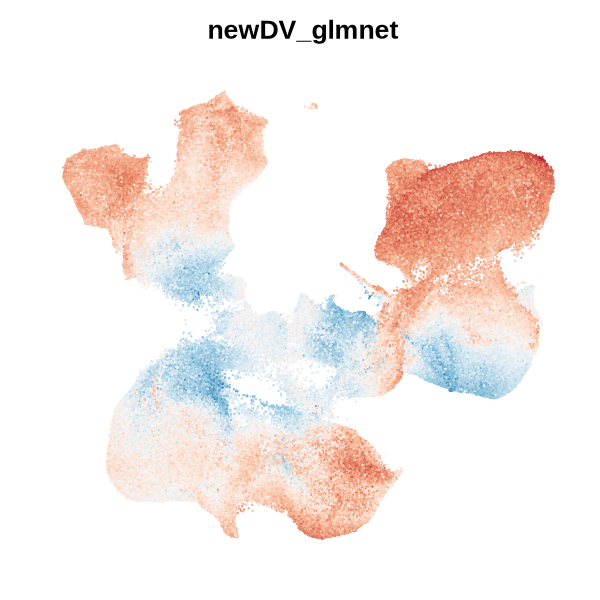

In [62]:
options(repr.plot.height=5, repr.plot.width=5)
FeaturePlot(braun, c('newDV_glmnet'), cols=bluewhitered_colscheme(30), reduction='umap',raster=FALSE) & NoAxes() & NoLegend()

## Predict for parse

In [63]:
seurat$newDV_glmnet <- (-1)*predict(new_DV, Embeddings(seurat,'scvi'), type='link') # -1 to have D - higher than Ventral

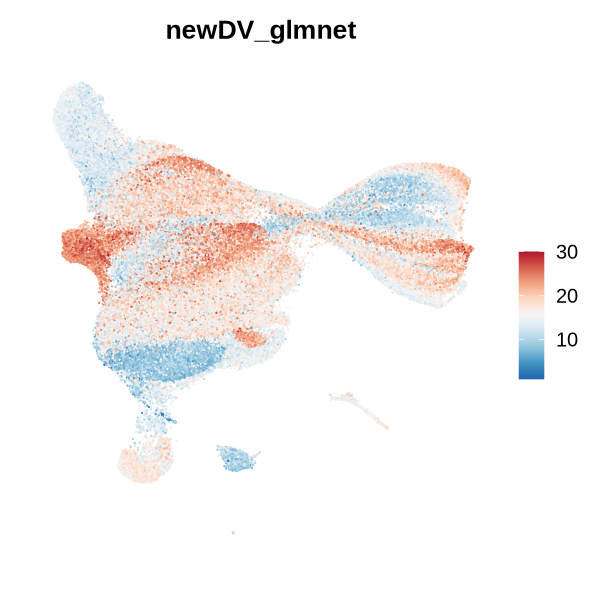

In [64]:
options(repr.plot.height=5, repr.plot.width=5)
FeaturePlot(seurat, c( 'newDV_glmnet'), cols=bluewhitered_colscheme(30), reduction='umap_rss',raster=FALSE) & NoAxes() 

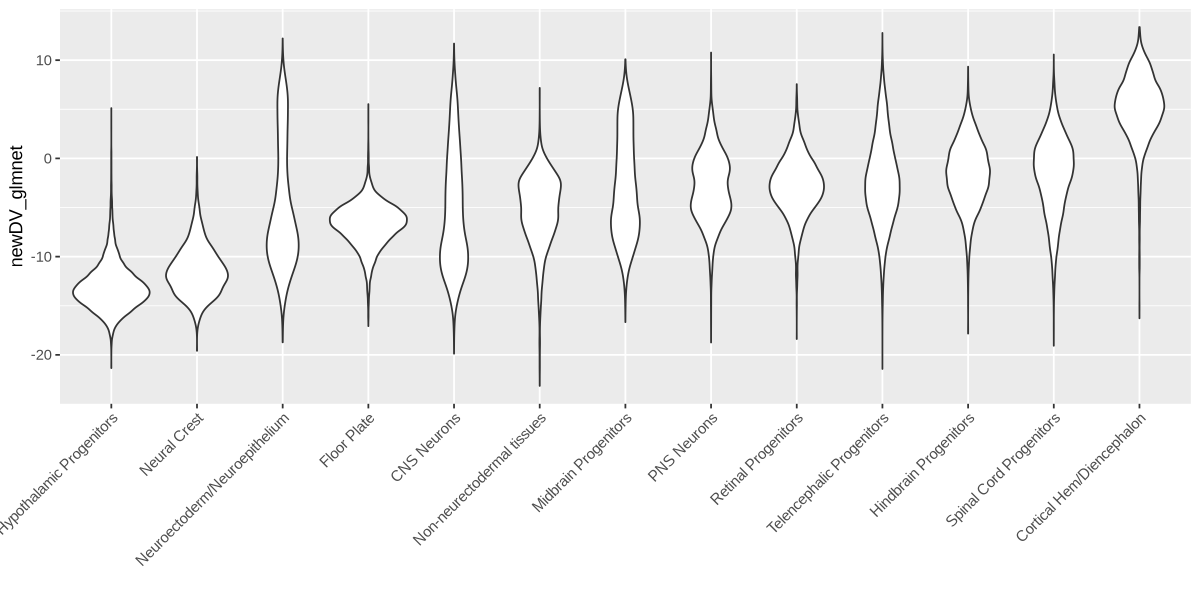

In [65]:
options(repr.plot.height=5, repr.plot.width=10)
library(ggplot2)
seurat@meta.data$fullname_v4 = with(seurat@meta.data, reorder(fullname_v4, newDV_glmnet, median))

p <- seurat@meta.data %>%
  ggplot( aes(x=fullname_v4, y=newDV_glmnet)) + 
    geom_violin() +
    xlab("class") +
    theme(legend.position="none") +
    xlab("")+ theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p

In [67]:
write.table(seurat@meta.data, paste0(path_data, 'meta_dv_parse_01_12.tsv'), sep="\t")

# AP

In [81]:
AP <- readRDS(paste0(path_data, 'model_RG_AP_glmnet.rds'))
seurat$AP_ZH <- predict(AP, Embeddings(seurat,'scvi')) 

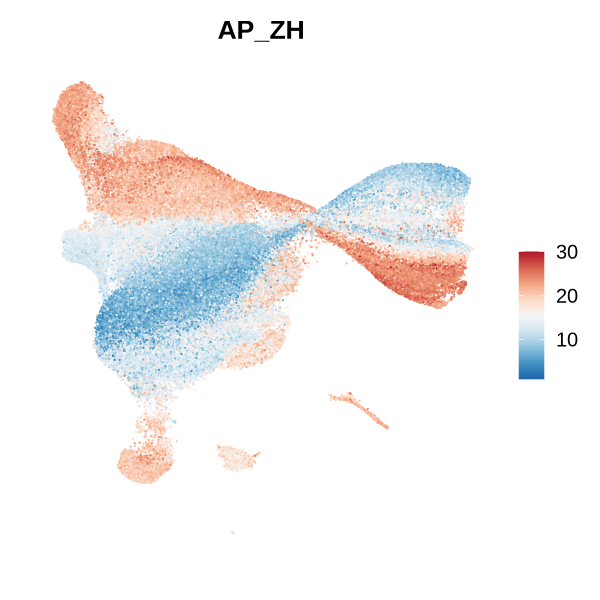

In [82]:
options(repr.plot.height=5, repr.plot.width=5)
FeaturePlot(seurat, c( 'AP_ZH'), cols=bluewhitered_colscheme(30), reduction='umap_rss',raster=FALSE) & NoAxes() 

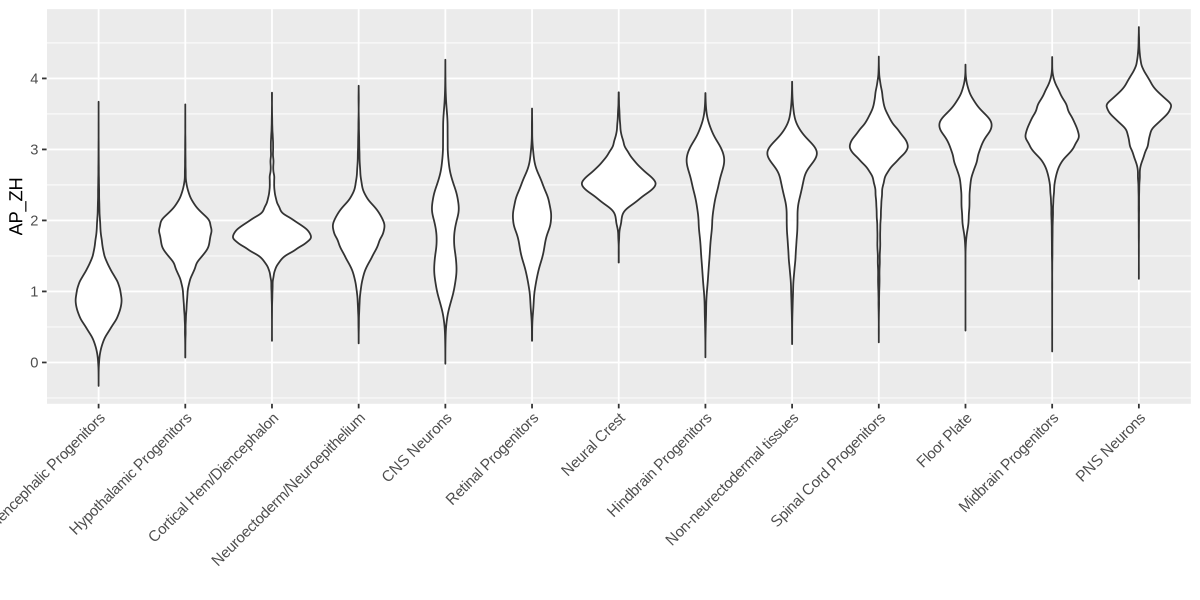

In [83]:
options(repr.plot.height=5, repr.plot.width=10)
library(ggplot2)
seurat@meta.data$fullname_v4 = with(seurat@meta.data, reorder(fullname_v4, AP_ZH, median))

p <- seurat@meta.data %>%
  ggplot( aes(x=fullname_v4, y=AP_ZH)) + 
    geom_violin() +
    xlab("class") +
    theme(legend.position="none") +
    xlab("")+ theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p

In [96]:
write.table(seurat@meta.data, paste0(path_data, 'meta_ap_parse_01_12.tsv'), sep="\t")